# Отчет по лабораторной работе 7.1

## Измерение углового распределения жесткой компоненты космического излучения
Конкс Эрик, Б01-818

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy import odr
from lmfit.models import LinearModel 

In [2]:
N1 = 1406
N2 = 2182
N_сл = 2 * 10**-7 * N1 * N2
#I = [834, 865, 724, 722]
I = [834, 865, 724, 722, 549]
I = [I_i - 532*0.8 for I_i in I]
I_err = [N_сл * 800 - 532*0.8 for _ in range(len(I))]
#θ = [0, 20, 40, 45]
θ = [0, 20, 45, 45, 65]
θ_err = [15 for _ in range(len(θ))]
lnI = [np.log(i) for i in I]
lnI_err = [I_err[i] / I[i] for i in range(len(I))]
cosθ = [np.cos(np.radians(θ_i)) for θ_i in θ]
ln_cosθ = [np.log(cosθ_i) for cosθ_i in cosθ]
cosθ_err = [np.sin(np.radians(θ[i])) * np.radians(θ_err[i]) for i in range(len(θ))]
ln_cosθ_err = [cosθ_err[i] / cosθ[i] for i in range(len(cosθ))]
ln_cosθ_err[0] = ln_cosθ_err[1] / 2
df = pd.DataFrame({'I': I, 'ΔI': I_err, 'lnI': lnI, 'ΔlnI': lnI_err,
                   'θ': θ, 'Δθ': θ_err, 'ln(cosθ)': ln_cosθ, 'Δln(cosθ)': ln_cosθ_err})
x = ln_cosθ
x_err = ln_cosθ_err
y = lnI
y_err = lnI_err
print(df)
print(f"Nсл = {N_сл}")

       I        ΔI       lnI      ΔlnI   θ  Δθ  ln(cosθ)  Δln(cosθ)
0  408.4  65.26272  6.012247  0.159801   0  15  0.000000   0.047644
1  439.4  65.26272  6.085410  0.148527  20  15 -0.062202   0.095287
2  298.4  65.26272  5.698435  0.218709  45  15 -0.346574   0.261799
3  296.4  65.26272  5.691710  0.220185  45  15 -0.346574   0.261799
4  123.4  65.26272  4.815431  0.528871  65  15 -0.861286   0.561431
Nсл = 0.6135784


In [3]:
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [18, 14]

In [4]:
f = lambda p, x: p[0] * x + p[1]
quad_model = odr.Model(f)
data = odr.RealData(x, y, sx=x_err, sy=y_err)
modr = odr.ODR(data, quad_model, beta0=[0.0, 0.0])
out = modr.run()
beta_opt = out.beta
beta_err = out.sd_beta
beta_name = ['a', 'b']
print('Fit parameter 1-sigma error y = a * x + b')
print('———————————–—————————————————————————————')
for i in range(len(beta_opt)):
    res = "{:.2f} +- {:.2f}".format(beta_opt[i], beta_err[i])
    print(f"{beta_name[i]} = {res}")
    
print("chisq = {:.2f}".format(out.res_var * (len(x) - len(beta_opt))))
print("\na_th = 1.6")

Fit parameter 1-sigma error y = a * x + b
———————————–—————————————————————————————
a = 1.25 +- 0.27
b = 6.08 +- 0.05
chisq = 0.42

a_th = 1.6


$$I(\theta)=I_0cos^n(\theta)$$

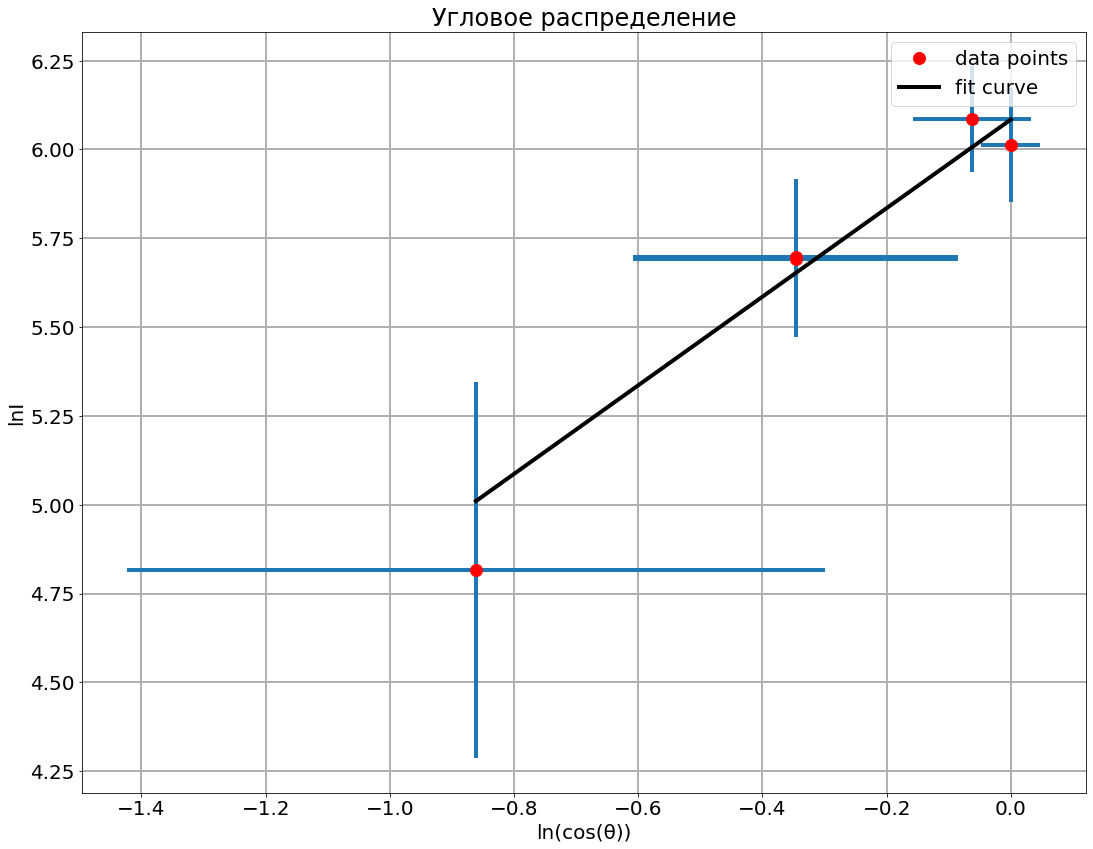

In [5]:
plot = plt.figure(num='Angular distribution')
plt.plot(x, y, 'ro', label='data points', markersize=12)
x_lin = np.linspace(x[-1], x[0], 1000)
plt.plot(x_lin, [f(beta_opt, x) for x in x_lin], color='black', linewidth=4, label='fit curve')
plt.errorbar(x, y, xerr=x_err, yerr=y_err, fmt="none", linewidth=4)
plt.grid(linewidth=2)
plt.legend()
plt.title('Угловое распределение')
plt.xlabel('ln(cos(θ))')
plt.ylabel('lnI')
plt.show()

In [6]:
def error(x):
    Δy_b = beta_err[1]
    Δy_a = beta_err[0] * x
    return np.sqrt((Δy_a)**2 + (Δy_b)**2)

Оценим время жизни мюона:

$$\frac{I(\theta)}{I(0)} = (cos\theta)^{1,6}\frac{e^{-L(\theta)\ /\ L}}{e^{-L_0\ /\ L}}$$

$$L(\theta) = \frac{L_0}{cos\theta}$$

$$L_0=15km$$

$$L = \beta c \tau_0 \frac{E_\mu}{m_\mu c^2}$$

$$E_\mu = 4 * 10^9 eV$$

$$m_\mu = 105.8 \ MeV / c^2$$

In [7]:
L0 = 15000
deg = 60
lnI_deg = f(beta_opt, np.log(np.cos(np.radians(deg))))
I_deg_err = error(np.log(np.cos(np.radians(deg))))
lnI0 = f(beta_opt, 0)
I0_err = error(np.log(np.cos(np.radians(0))))
cos = np.cos(np.radians(deg))
E = 4 * 10**9
mc2 = 105.8 * 10**6
c = 3 * 10**8
𝜏0 = -( L0*(cos - 1) ) / ( cos * E * c / mc2 * (lnI_deg - lnI0 - 1.6*np.log(cos)) )
𝜏0_err_1 = 𝜏0 / (lnI_deg - lnI0 - 1.6*np.log(cos)) * I_deg_err
𝜏0_err_2 = 𝜏0 / (lnI0 - lnI0 - 1.6*np.log(cos)) * I0_err
𝜏0_err = np.sqrt(𝜏0_err_1**2 + 𝜏0_err_2**2)
print(f"𝜏0    = {np.round(𝜏0*10**6)} +- {int(np.round(𝜏0_err*10**6))}  10^-6 с")
print(f"𝜏0_th = 2.2       10^-6 с")

𝜏0    = 5.0 +- 4  10^-6 с
𝜏0_th = 2.2       10^-6 с
